# Forecasting AI and ML Job Trends with SARIMA

Here, we filter out AI/ML/DS jobs using Keyword Matching

## Dependencies

In [1]:
import re
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

from wordcloud import WordCloud

## Data Loading

In [2]:
filename = "data/a_job_postings_normalized.parquet"
job_postings = pd.read_parquet(filename)

In [39]:
print(f"{len(job_postings):,} job postings loaded from {filename}")
job_postings.sample(5)

1,296,381 job postings loaded from data/a_job_postings_normalized.parquet


,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count
1248924,2024-01-21 05:49:44.484419+00,t,t,f,senior project manager,grant thornton australia,"adelaide, south australia, australia",2024-01-14,campbelltown,australia,building consultant,mid senior,onsite,"[project management, business analysis, stakeh...",18
775852,2024-01-19 09:45:09.215838+00,t,t,f,office administrator i general administrative,builders firstsource,"houston, tx",2024-01-13,texas,united states,passenger service representative,mid senior,onsite,"[customer service, verbal communication, writt...",18
467368,2024-01-19 09:45:09.215838+00,t,t,f,data scientist associate,tencent,"palo alto, ca",2024-01-12,santa clara,united states,biologist,associate,onsite,"[data science, machine learning, deep learning...",26
657105,2024-01-19 09:45:09.215838+00,t,t,f,head teller,queensborough national bank and trust co.,"savannah, ga",2024-01-13,savannah,united states,manager records analysis,mid senior,onsite,"[leadership, teamwork, customer service, banki...",14
213606,2024-01-19 09:45:09.215838+00,t,t,f,lead sales associate-pt,dollar general,"eldred, pa",2024-01-12,allentown,united states,circulation-sales representative,mid senior,onsite,"[cashier, stocker, planograms, customer servic...",16


## Keyword Likelihood Analysis

Use 150 most common AI/ML job terms

In [4]:
ai_ml_terms = """
artificial intelligence, machine learning, deep learning, neural networks, computer vision, natural language processing, large language model, reinforcement learning, supervised learning, unsupervised learning, semi-supervised learning, transfer learning, predictive modeling, classification, regression, clustering, convolutional neural networks, cnn, rnn, long short-term memory, lstm, gan, generative adversarial networks, support vector machine, svm, random forests, decision trees, ensemble learning, feature engineering, feature selection, data preprocessing, data mining, big data, data science, data analysis, data visualization, sentiment analysis, chatbots, speech recognition, image recognition, object detection, time series analysis, recommender systems, autonomous systems, robotics, chatbot development, nlp algorithms, tensorFlow, keras, pytorch, scikit-learn, openai, machine learning algorithms, model training, model evaluation
"""

ai_ml_frameworks = """
Python, R, Julia, SQL, Apache Spark, Databricks, Jupyter Notebook, Google Cloud AI Platform, Amazon SageMaker, Microsoft Azure Machine Learning, Docker, Kubernetes, Git, GitHub, Anaconda, Weights & Biases, MLflow, Apache Kafka, Airflow, Tableau, Power BI, Looker, MATLAB, Scala, C++, Java, PySpark, Databricks, Snowflake, BigQuery, Vertex AI, OpenCV, NLTK, spaCy, Gensim, Hugging Face Transformers, Ray, Dask, Kedro, DVC (Data Version Control), Great Expectations, Kedro, Weights & Biases, Streamlit, FastAPI, Dash, Flask, XGBoost, LightGBM
"""

ai_ml_acronyms = """
RAG, LLM, GenAI, ML, DL, NLP, CV, RL, GAN, CNN, RNN, LSTM, SVM, SAA, AGI, AIoT, HCI, TF, PyTorch, KNN, SVD, BERT, GPT, T5, VAE, BIM, BOM, IoT, CICD, MLOps, AI/ML, API, RPA, ETL, DNN, RNN, BFS, AIaaS, MLaaS, DLaaS, Jupyter, K8s, EDA, RNN, BERT, VQA, CVPR, MT, FL, AI-ML, Keras, XLNet
"""

ai_terms_list = [item.strip() for item in ai_ml_terms.split(",")]
ai_ml_frameworks_list = [item.strip() for item in ai_ml_frameworks.split(",")]
ai_acronyms_list = [item.strip() for item in ai_ml_acronyms.split(",")]

ai_ml_keywords = set(ai_terms_list + ai_ml_frameworks_list + ai_acronyms_list)

print(f"Number of AI/ML keywords: {len(ai_ml_keywords)}")


Number of AI/ML keywords: 150


In [5]:
def combine_row_text(row):
    return f"{row['job_title']} {row['search_position']} {row['company']} {', '.join(row['job_skills'])}".lower()

In [74]:
def classify_with_keywords(df):
    df = df.copy()
    # Combine relevant columns into a single text column
    df["job_description"] = df.apply(
        lambda row: combine_row_text(row),
        axis=1,
    )

    # Create a pattern with word boundaries for all keywords
    pattern = "|".join(
        r"\b" + re.escape(keyword.lower()) + r"\b" for keyword in ai_ml_keywords
    )

    # Count occurrences of keywords in the combined text
    df["keyword_count"] = df["job_description"].str.count(pattern, flags=re.IGNORECASE)

    # Calculate likelihood and reason
    df["keyword_likelihood"] = df["keyword_count"].apply(
        lambda count: min(100, int((count / len(ai_ml_keywords)) * 100))
    )

    return df

In [75]:
job_postings_keyword = classify_with_keywords(job_postings)

In [76]:
ai_ml_job_postings = job_postings_keyword[job_postings_keyword['keyword_likelihood'] > 0]
print(f"Number of potential AI/ML jobs: {len(ai_ml_job_postings):,}")

Number of potential AI/ML jobs: 62,621


## Keyword Analysis

Filter the DataFrame based on the minimum keyword likelihood.

In [77]:
def filter_by_likelihood(df, min_likelihood=0):
    df = df.copy()
    return df[df["keyword_likelihood"] >= min_likelihood]

Plot the distribution of keyword likelihood across job postings.

In [78]:
def plot_keyword_likelihood_distribution(df, min_liklihood=0):    
    likelihood_distribution = (
    df["keyword_likelihood"]
        .value_counts()
        .sort_index()
    )

    plt.figure(figsize=(8, 5))
    likelihood_distribution.plot(kind="bar", color="blue", alpha=0.7)
    plt.title(f"Distribution of Keyword Likelihood Count (> {min_liklihood})")
    plt.xlabel("Keyword Likelihood")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.show()

Perform frequency analysis of AI-related skills across job postings.

In [79]:
def frequency_analysis_of_skills(df):
    all_skills = [skill.lower() for skills in df["job_skills"] for skill in skills]
    return Counter(all_skills)

Plot the top N AI and ML skills in demand.

In [80]:
def visualize_skill_demand(df, top_n=20, min_liklihood=0):
    title = (
        f"Top {top_n} AI and ML Skills in Demand (> {min_liklihood} Likelihood count)"
        if min_liklihood > 0
        else f"Top {top_n} AI and ML Skills in Demand"
    )
    all_skills = [skill for sublist in df["job_skills"] for skill in sublist]
    skill_counts = Counter(all_skills)

    top_k_skills = skill_counts.most_common(top_n)
    skills, counts = zip(*top_k_skills)

    plt.figure(figsize=(8, 6))
    plt.barh(skills, counts, color="blue", alpha=0.9)
    plt.title(title)
    plt.xlabel("Number of Job Postings")
    # plt.ylabel('Skills')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.show()

Create a word cloud visualization of popular AI skills

In [81]:
def create_word_cloud(df):
    skill_counts = frequency_analysis_of_skills(df)

    wordcloud = WordCloud(
        width=800, height=400, background_color="white"
    ).generate_from_frequencies(skill_counts)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [82]:
def analyze_jobs(df, min_likelihood = 5):
    filtered_jobs = filter_by_likelihood(df, min_likelihood=min_likelihood)
    
    display(Markdown(f"### **Keword Analysis for Mimumum Likelihood count of {min_likelihood}**"))
    display(Markdown(f"Percentage of jobs with at least {min_likelihood} likelihood count: **{filtered_jobs.shape[0] / job_postings.shape[0]:.2%}**"))
    display(Markdown(f"Number of jobs with at least {min_likelihood} likelihood count: **{filtered_jobs.shape[0]:,}**"))

    plot_keyword_likelihood_distribution(filtered_jobs, min_liklihood=min_likelihood)

    visualize_skill_demand(filtered_jobs, top_n=20, min_liklihood=min_likelihood)

    create_word_cloud(filtered_jobs)

### **Keword Analysis for Mimumum Likelihood count of 0**

Percentage of jobs with at least 0 likelihood count: **4.83%**

Number of jobs with at least 0 likelihood count: **62,621**

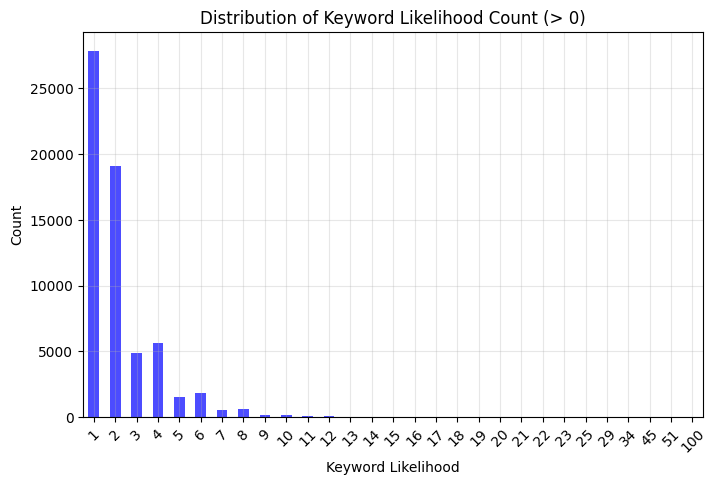

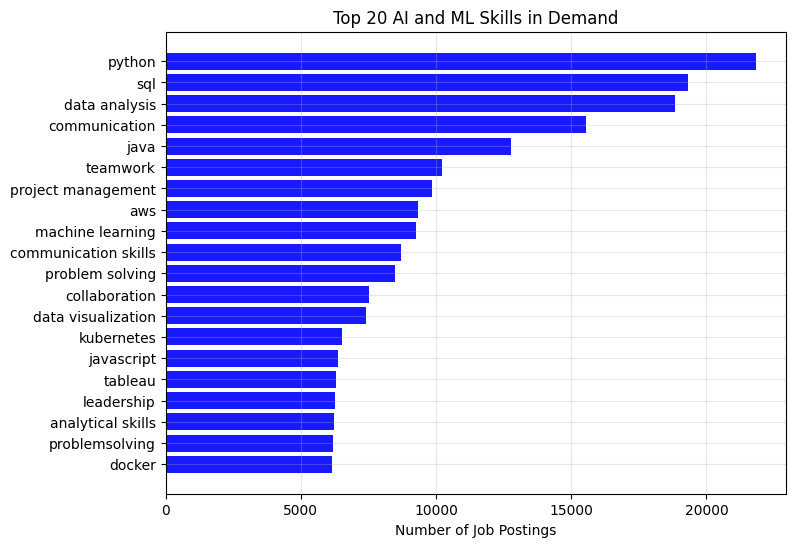

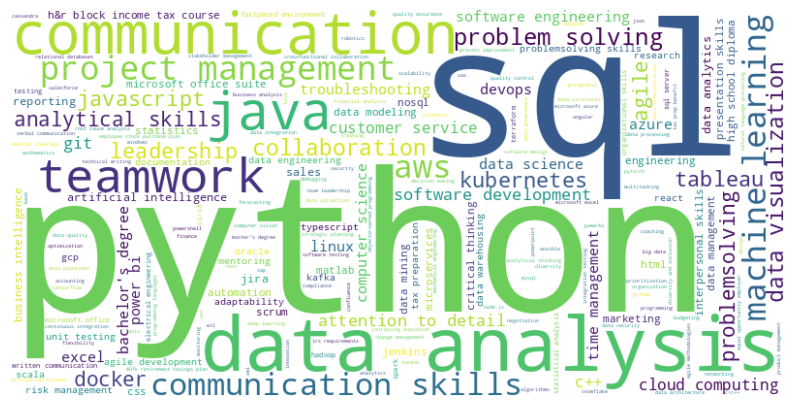

In [83]:
analyze_jobs(ai_ml_job_postings, min_likelihood=0)

### **Keword Analysis for Mimumum Likelihood count of -2**

Percentage of jobs with at least -2 likelihood count: **4.83%**

Number of jobs with at least -2 likelihood count: **62,621**

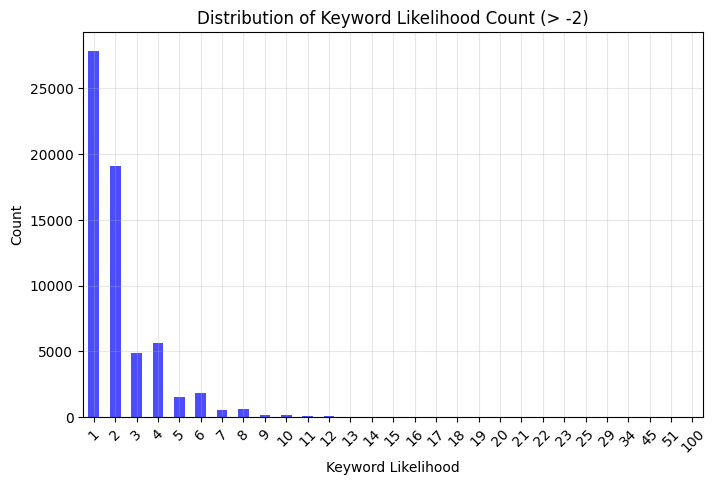

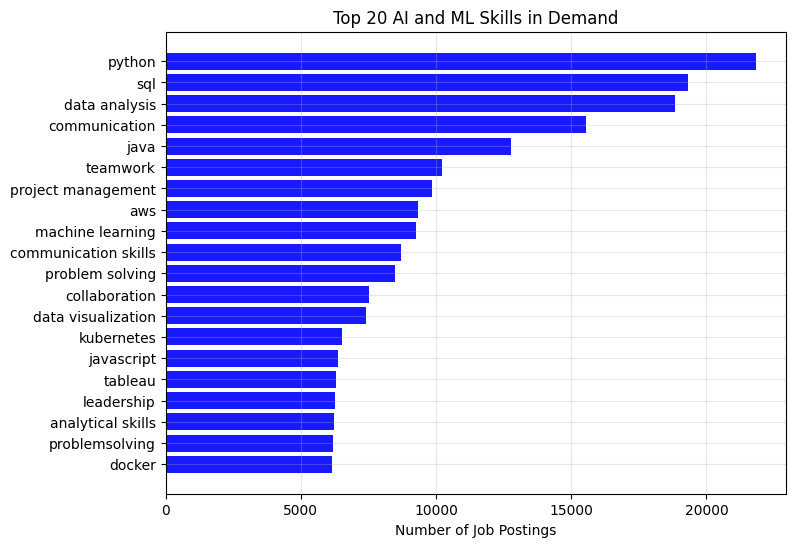

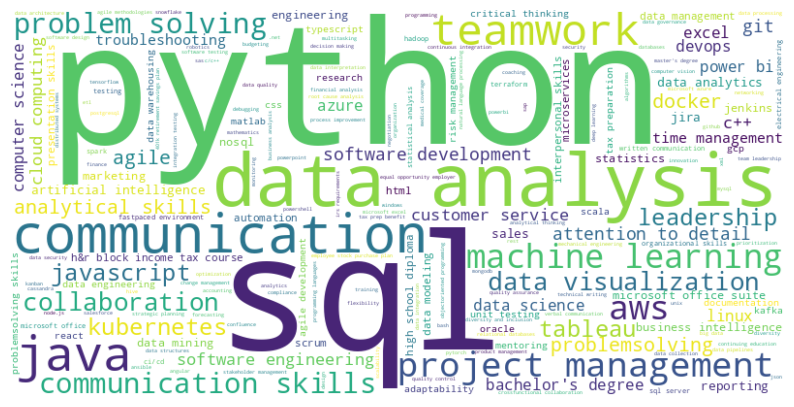

In [84]:
analyze_jobs(ai_ml_job_postings, min_likelihood=-2)

## Appending labels to jobs

In [85]:
job_postings_keyword.head(5)

,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,job_description,keyword_count,keyword_likelihood
0,2024-01-21 07:12:29.00256+00,t,t,f,account executive - dispensing (norcal/norther...,bd,"san diego, ca",2024-01-15,coronado,united states,color maker,mid senior,onsite,"[medical equipment sales, key competitors, ter...",25,account executive - dispensing (norcal/norther...,0,0
1,2024-01-21 07:39:58.88137+00,t,t,f,registered nurse - rn care manager,trinity health mi,"norton shores, mi",2024-01-14,grand haven,united states,director nursing service,mid senior,onsite,"[nursing, bachelor of science in nursing, mast...",17,registered nurse - rn care manager director nu...,0,0
2,2024-01-21 07:40:00.251126+00,t,t,f,restaurant supervisor - the forklift,wasatch adaptive sports,"sandy, ut",2024-01-14,tooele,united states,stand-in,mid senior,onsite,"[restaurant operations management, inventory m...",43,restaurant supervisor - the forklift stand-in ...,0,0
3,2024-01-21 07:40:00.308133+00,t,t,f,independent real estate agent,howard hanna | rand realty,"englewood cliffs, nj",2024-01-16,pinehurst,united states,real-estate clerk,mid senior,onsite,"[real estate, customer service, sales, negotia...",18,independent real estate agent real-estate cler...,0,0
4,2024-01-21 08:08:19.663033+00,t,t,f,registered nurse (rn),trinity health mi,"muskegon, mi",2024-01-14,muskegon,united states,nurse practitioner,mid senior,onsite,"[nursing, bsn, medical license, virtual rn, nu...",9,registered nurse (rn) nurse practitioner trini...,0,0


In [86]:
def append_labels(df, label_min_likelihood):
    df = df.copy()
    df["label"] = (df["keyword_likelihood"] > label_min_likelihood).astype(int)
    return df

In [98]:
# Using the unfiltered job postings
job_postings_with_labels = append_labels(job_postings_keyword, label_min_likelihood=2)

# print count of labels
job_postings_with_labels["label"].value_counts()

label
0    1280726
1      15655
Name: count, dtype: int64

In [104]:
job_postings_with_labels.sample(5)

,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,job_description,keyword_count,keyword_likelihood,label
105460,2024-01-19 18:31:12.858439+00,t,t,f,pediatric private duty nurse,jobs for humanity,"port arthur, tx",2024-01-16,port arthur,united states,nurse private duty,mid senior,onsite,"[rn/lvn license, current cpr certification, el...",14,pediatric private duty nurse nurse private dut...,0,0,0
33121,2024-01-19 12:28:38.733364+00,t,t,f,residential sales consultant,"rollins, inc.","richmond, va",2024-01-14,montpelier,united states,sales agent insurance,mid senior,onsite,"[sales, communication, customer service, relat...",17,residential sales consultant sales agent insur...,0,0,0
592550,2024-01-19 09:45:09.215838+00,t,t,f,business development executive - graduate,eldredge furniture,"city of london, england, united kingdom",2024-01-13,basildon,united kingdom,director social,mid senior,onsite,"[business development, sales, marketing, clien...",18,business development executive - graduate dire...,0,0,0
765264,2024-01-20 04:02:44.666308+00,t,t,f,radiographer | hope island qld | ft or pt | 04...,gorilla jobs,"hope island, queensland, australia",2024-01-14,gold coast,australia,radiologic technologist,mid senior,onsite,"[medical imaging, radiography, ultrasound, pai...",11,radiographer | hope island qld | ft or pt | 04...,0,0,0
656883,2024-01-19 09:45:09.215838+00,t,t,f,manufacturing manager,schneider electric,"el paso, tx",2024-01-13,socorro,united states,manager personnel,mid senior,onsite,"[manufacturing management, safety programs, pr...",70,manufacturing manager manager personnel schnei...,2,1,0


Save the job postings with labels

In [107]:
filename = "data/b_job_postings_with_labels.parquet"
job_postings_with_labels.to_parquet(filename, index=False)

print(f"Data with labels saved to {filename}")

Data with labels saved to data/b_job_postings_with_labels.parquet
